# Graph Theory based Recommendation Engine


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#Import data set 
df = pd.read_csv(r'https://raw.githubusercontent.com/PrajwalMasulkar/Project/main/Dataset/Online-sale-excel-main/Online_retail.csv', header = 0)

In [3]:
print('dataset dimensions are:', df.shape)
df.describe(include = 'all')

dataset dimensions are: (10000, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,10000,10000,9958,10000.000000,10000,10000.000000,7709.000000,10000
unique,512,2015,1981,NaN,442,NaN,NaN,15
top,536876,22632,HAND WARMER UNION JACK,NaN,2010-12-03 11:36:00,NaN,NaN,United Kingdom
freq,593,63,59,NaN,593,NaN,NaN,9403
mean,NaN,NaN,NaN,7.828600,NaN,3.837412,15615.462576,NaN
std,NaN,NaN,NaN,104.322417,NaN,14.310148,1756.540802,NaN
min,NaN,NaN,NaN,-9360.000000,NaN,0.000000,12395.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,14388.000000,NaN
50%,NaN,NaN,NaN,2.000000,NaN,2.510000,15605.000000,NaN
75%,NaN,NaN,NaN,8.000000,NaN,4.210000,17228.000000,NaN


In [4]:
#Taking a smaller sample dataset
df_sample = df.iloc[:1000]

In [5]:
df_sample.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
#Data pre-processing 

#Delete rows with no Customer ID 
cleaned_retail = df_sample.loc[pd.isnull(df_sample.CustomerID) == False]

#Creating a lookup table
item_lookup = cleaned_retail[['StockCode', 'Description']].drop_duplicates()
item_lookup['StockCode'] = item_lookup.StockCode.astype(str)

#'data cleaning' the raw data
cleaned_retail['CustomerID'] = cleaned_retail.CustomerID.astype(int)
cleaned_retail = cleaned_retail[['StockCode', 'Quantity', 'CustomerID']]
grouped_cleaned = cleaned_retail.groupby(['CustomerID', 'StockCode']).sum().reset_index()
grouped_cleaned.Quantity.loc[grouped_cleaned.Quantity == 0] = 1
grouped_purchased = grouped_cleaned.query('Quantity > 0')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
#Counting number of products and number of customers in the reduced dataset 
no_products = len(grouped_purchased.StockCode.unique())
no_customers = len(grouped_purchased.CustomerID.unique())
print('Number of customers in dataset:', no_customers)
print('Number of products in dataset:', no_products)

Number of customers in dataset: 46
Number of products in dataset: 586


AxesSubplot(0.125,0.125;0.62x0.755)


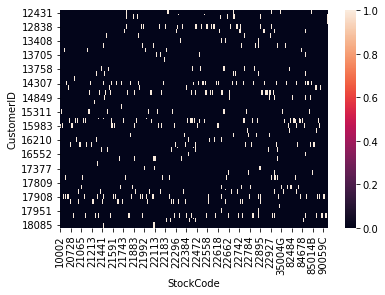

In [8]:
#Turning raw data to pivot ('ratings' matrix)
ratings = grouped_purchased.pivot(index = 'CustomerID', columns='StockCode', values='Quantity').fillna(0).astype('int')
#Binarize the ratings matrix (indicate only if a customer has purchased a product or not)
ratings_binary = ratings.copy()
ratings_binary[ratings_binary != 0] = 1
import seaborn as sns
print(sns.heatmap(ratings_binary))

In [9]:
#Initializing zeros dataframe for product interactions
products_integer = np.zeros((no_products,no_products))

#Counting how many times each product pair has been purchased
print('Counting how many times each pair of products has been purchased...')
for i in range(no_products):
    for j in range(no_products):
        if i != j:
            df_ij = ratings_binary.iloc[:,[i,j]] #createing a temporary df with only i and j products as columns
            sum_ij = df_ij.sum(axis=1)
            pairings_ij = len(sum_ij[sum_ij == 2]) #if s1_ij == 2 it means that both products were purchased by the same customer
            products_integer[i,j] = pairings_ij
            products_integer[j,i] = pairings_ij

Counting how many times each pair of products has been purchased...


AxesSubplot(0.125,0.125;0.62x0.755)


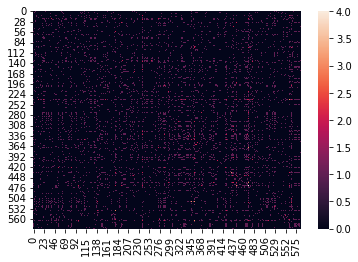

In [10]:
import seaborn as sns
print(sns.heatmap(pd.DataFrame(products_integer)))

In [11]:
#Counting how many customers have purchased each item
print('Counting how many times each individual product has been purchased...')
times_purchased = products_integer.sum(axis = 1)

Counting how many times each individual product has been purchased...


In [12]:
#Constructing final weighted matrix of item interactions
print('Building weighted product matrix...')
products_weighted = np.zeros((no_products,no_products))
for i in range(no_products):
    for j in range(no_products):
        if (times_purchased[i]+times_purchased[j]) !=0: #make sure you do not divide with zero
            products_weighted[i,j] = (products_integer[i,j])/(times_purchased[i]+times_purchased[j])
print(pd.DataFrame(products_weighted))

Building weighted product matrix...
      0         1    2         3    ...       582       583  584   585
0    0.00  0.000000  0.0  0.000000  ...  0.000000  0.000000  0.0  0.02
1    0.00  0.000000  0.0  0.000000  ...  0.006849  0.006849  0.0  0.00
2    0.00  0.000000  0.0  0.000000  ...  0.000000  0.000000  0.0  0.00
3    0.00  0.000000  0.0  0.000000  ...  0.000000  0.000000  0.0  0.00
4    0.00  0.000000  0.0  0.011765  ...  0.000000  0.000000  0.0  0.00
..    ...       ...  ...       ...  ...       ...       ...  ...   ...
581  0.00  0.006849  0.0  0.000000  ...  0.006849  0.006849  0.0  0.00
582  0.00  0.006849  0.0  0.000000  ...  0.000000  0.006849  0.0  0.00
583  0.00  0.006849  0.0  0.000000  ...  0.006849  0.000000  0.0  0.00
584  0.00  0.000000  0.0  0.000000  ...  0.000000  0.000000  0.0  0.00
585  0.02  0.000000  0.0  0.000000  ...  0.000000  0.000000  0.0  0.00

[586 rows x 586 columns]


In [13]:
#Getting list of item labels
nodes_codes = np.array(ratings_binary.columns).astype('str')
item_lookup_dict = pd.Series(item_lookup.Description.values,index=item_lookup.StockCode).to_dict()
nodes_labels = [item_lookup_dict[code] for code in nodes_codes]

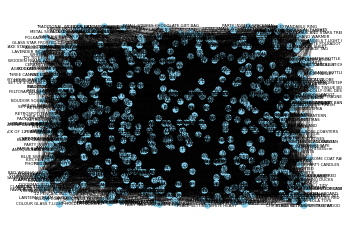

In [14]:
#Creating Graph object using the weighted product matrix as adjacency matrix
G = nx.from_numpy_matrix(products_weighted)
pos=nx.random_layout(G)
labels = {}
for idx, node in enumerate(G.nodes()):
    labels[node] = nodes_labels[idx]

nx.draw_networkx_nodes(G, pos , node_color="skyblue", node_size=30)
nx.draw_networkx_edges(G, pos,  edge_color='k', width= 0.3, alpha= 0.5)
nx.draw_networkx_labels(G, pos, labels, font_size=4)
plt.axis('off')
plt.show() # displaying the bipartite graph for the products purchased

In simple words what we have done in the above code cell is we know that we have 2 sets namely customers and products or assets bought by them which is represented as follows, where:

$\text{C = {$c_1$,$c_2$,$c_3$,$c_4$,$\dots$}}$ represent the customer set.

$\text{A = {$a_1$,$a_2$,$a_3$,$a_4$,$\dots$}}$ represent the assets or products set.

where $|C|>>|A|$.

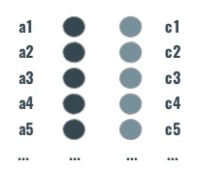

Now map every customer with the product they purchased from the assets set.

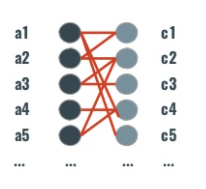

Considering the fact that both sets are disjoint and independent and every mapping can be regarded as an edge from one node to other node, we can conclude that this forms a **Bipartite Graph**.

Now the above graph can be re-constructed as follows:

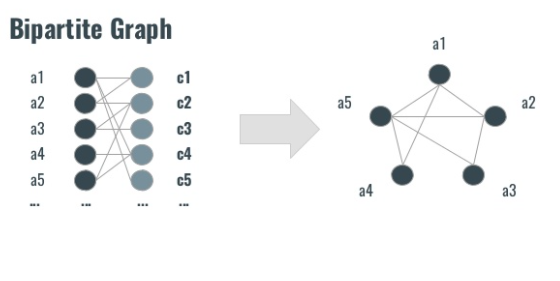

Now, Each edge can be weighted by a similarity measure(**s**), where it gives the probability of how often a customer buys a pair of products,  where it is calculated as follows:

$s_{(i,j)} = \frac{|C(a_i,a_j)|}{|C(a_i)|+|C(a_j)|}$

- $s_{(i,j)} =$ similarity measure between products $a_i$ and $a_j$.

- $|C(a_i,a_j)| = $ no. of customers who bought both products $a_i$ and $a_j$.

- $|C(a_i)| = $no.of customers who bought product $a_i$

- $|C(a_j)| = $no.of customers who bought product $a_j$

In [15]:
#Dividing each element in products_weighted dataframe with the maximum of each row.
#This will normalize values in the row and we can perceive it as the possibility af a customer also buying
#product in column j after showing interest for the product in row i

#Turn into dataframe
products_weighted_pd = pd.DataFrame(products_weighted, columns = nodes_labels)
products_weighted_pd.set_index(products_weighted_pd.columns, 'product', inplace=True)

products_prob = products_weighted_pd.divide(products_weighted_pd.max(axis = 1), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only
  import sys


In [16]:
#Making recommendations
basket = ['HOME BUILDING BLOCK WORD']
#selecting the number of relevant items to suggest
no_of_suggestions = 3

all_of_basket = products_prob[basket]
all_of_basket = all_of_basket.sort_values(by = basket, ascending=False)
suggestions_to_customer = list(all_of_basket.index[:no_of_suggestions])

print('You may also consider buying:', suggestions_to_customer)

You may also consider buying: ['LOVE BUILDING BLOCK WORD', 'BLUE COAT RACK PARIS FASHION', 'RIBBON REEL MAKING SNOWMEN ']


The output shows the top n number of suggestions we want to suggest a customer.